# Ejercicio 4: Bayes ingenuo


---

Programen su propia implementación de naive Bayes. Utilicen las técnicas vistas para procesamiento del lenguaje natural para procesar el dataset presente en la carpeta Datos de la clase 5 y hagan predicciones con su modelo sobre si el texto es relevante o no (columna relevance). Su predicción podría mejorar mucho si balancean su dataset antes de pasarlo por su modelo.


## 1. Instalación e importación de Librerías
Importamos todas las librerías necesarias para el procesamiento de texto, modelado, balanceo y visualización.

In [ ]:
!pip install contractions

import pandas as pd # Para manipular datos en formato DataFrame
import numpy as np # Para operaciones numéricas
from math import log, pi,sqrt,exp
import re # Libreria de expresiones regulares
import string # Libreria de cadena de caracteres
import contractions # Expande contracciones en inglés por ej. 'don´t' a 'do not'
import nltk # Herramientas para procesamiento de lenguaje natural (tokenización, lematización, stopwords)
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split # Para dividir datos en entrenamiento y prueba
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE # Balanceo de clases en SMOTE
from matplotlib import pyplot as plt #Visualización de resultados


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 6.4 MB/s eta 0:00:00


## 2. Parámetros principales del experimento

Definimos los parámetros clave para facilitar cambios y experimentación.



In [ ]:
MAX_FEATURES = 1200     # Número máx de palabras (features) a considerar
NGRAM_RANGE = (1, 2)    # Rango de n-gramas (palabras o pares de palabras)
ALPHA = 1.0             # Suavizado de Laplace para evitar probabilidades nulas
TEST_SIZE = 0.2         # Proporción de datos para test
RANDOM_STATE = 42       # Semilla para reproducibilidad

## 3. Carga y Exploración de los Datos
Cargamos el dataset y realizamos una exploración inicial de las columnas y del cnotenido textual. De esta manera verificamos la estructura de los datos y nos aseguramos que la columna `text` contiene la información relevante para el análisis.


In [ ]:
# Cargar archivo
df = pd.read_csv('US-Economic-News.csv', encoding_errors='ignore')

# Ver columnas
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [ ]:
df['text'].head()

,text
0,NEW YORK -- Yields on most certificates of dep...
1,The Wall Street Journal Online</br></br>The Mo...
2,WASHINGTON -- In an effort to achieve banking ...
3,The statistics on the enormous costs of employ...
4,NEW YORK -- Indecision marked the dollar's ton...


## 4. Implementación del Clasificador Naive Bayes

En este bloque se define la clase `NaiveBayesClassifier` desde cero para que soporte distintas variantes, entre ellas:

*   **Bernoulli:** Para variables binarias (presencia ausencia de palabras).
*   **Multinomial:** Para conteo de palabras.
*   **Gaussiano:** Para variables continuas (no usado en este caso, solo para mostrar que la clase puede adaptarse a otros tipos de datos).


In [ ]:
# Implementa un clasificador Naive Bayes
class NaiveBayesClassifier:
    def __init__(self, model_type='bernoulli', alpha=1.0):
        """
        Inicializa el clasificador.

        model_type: tipo de modelo ['bernoulli', 'gaussian', 'multinomial']
        alpha: parámetro de suavizado de Laplace (evita divisiones por cero)
        """
        assert model_type in ['bernoulli', 'gaussian', 'multinomial'], 'Tipo de modelo inválido'
        self.model_type = model_type
        self.alpha = alpha
        self.class_summary = {}  # Diccionario para guardar los parámetros por clase
        self.n_features_ = None  # Cantidad de características del dataset

    def fit(self, X, y):
        """
        Ajusta el modelo a los datos.

        X: matriz de características (numpy array)
        y: vector de etiquetas de clase
        """
        X = np.array(X)
        y = np.array(y)
        self.n_features_ = X.shape[1]
        classes = np.unique(y)  # Lista de clases únicas

        # Procesar cada clase por separado
        for class_label in classes:
            X_class = X[y == class_label]  # Subconjunto de datos de la clase
            prior_proba = len(X_class) / len(X)  # Probabilidad a priori de la clase

            if self.model_type == 'bernoulli':
                # Calcular probabilidad de que cada característica sea 1 (presente)
                feature_probs = (np.sum(X_class, axis=0) + self.alpha) / (X_class.shape[0] + 2 * self.alpha)
                self.class_summary[class_label] = {
                    'prior': prior_proba,
                    'feature_probs': feature_probs,
                    'feature_inv_probs': 1 - feature_probs  # Probabilidades para valores 0
                }

            elif self.model_type == 'gaussian':
                # Calcular media y desviación estándar para cada característica
                means = X_class.mean(axis=0)
                stds = X_class.std(axis=0) + 1e-9  # Se suma pequeño valor para evitar división por cero
                self.class_summary[class_label] = {
                    'prior': prior_proba,
                    'means': means,
                    'stds': stds
                }

            elif self.model_type == 'multinomial':
                # Calcular conteo de ocurrencias por característica
                feature_counts = np.sum(X_class, axis=0)
                total_count = np.sum(feature_counts) + self.alpha * self.n_features_
                feature_probs = (feature_counts + self.alpha) / (total_count) # Probabilidad condicional con suavizado
                self.class_summary[class_label] = {
                    'prior': prior_proba,
                    'feature_probs': feature_probs
                }

        return self

    def _gaussian_prob(self, x, mean, std):
        """
        Calcula la probabilidad de x dado una distribución normal (gaussiana).

        x: valor observado
        mean: media
        std: desviación estándar
        """
        exponent = exp(-((x - mean) ** 2) / (2 * std ** 2))
        return (1 / (sqrt(2 * pi) * std)) * exponent

    def predict(self, X):
        """
        Realiza predicciones para un conjunto de datos X.

        X: matriz de ejemplos a predecir
        """
        X = np.array(X)
        predictions = []

        for row in X:
            posteriors = {}  # Probabilidades finales por clase

            for class_label, summary in self.class_summary.items():
                p = summary['prior']  # Inicia con la probabilidad a priori

                if self.model_type == 'bernoulli':
                    for i in range(self.n_features_):
                        if row[i] == 1:
                            # Multiplica por la probabilidad condicional de que la característica esté presente
                            p *= summary['feature_probs'][i]
                        else:
                            # Multiplica por la probabilidad de que esté ausente
                            p *= summary['feature_inv_probs'][i]

                elif self.model_type == 'gaussian':
                    for i in range(self.n_features_):
                        # Multiplica por la probabilidad bajo la distribución normal
                        p *= self._gaussian_prob(row[i], summary['means'][i], summary['stds'][i])

                elif self.model_type == 'multinomial':
                    for i in range(self.n_features_):
                        # Multiplica la probabilidad de la característica elevada al número de veces que aparece
                        p *= summary['feature_probs'][i] ** row[i]


                # Almacena la probabilidad final para esta clase
                posteriors[class_label] = p

            # Selecciona la clase con la mayor probabilidad
            predictions.append(max(posteriors, key=posteriors.get))

        return predictions



## 5. Preprocesamiento de texto (limpieza)

Se realiza la limpieza del texto: expansión de contracciones, eliminación de etiquetas HTML, signos de puntuación, números y espacios extra, conversión a minúsculas, tokenización, lematización y remoción de stopwords.

In [ ]:
# Expansión de contracciones
df['text'] = df['text'].apply(contractions.fix)

def clean_text_round1(text):
    text = str(text).lower()  # Asegura que sea texto y pasa a minúsculas

    text = re.sub(r'<.*?>', ' ', text)                         # Elimina etiquetas HTML (como <br>)
    text = re.sub(r'[\r\n\t]+', ' ', text)                     # Elimina saltos de línea y tabulaciones
    text = re.sub(r'\[.*?\]', ' ', text)                       # Elimina contenido entre corchetes
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)  # Signos de puntuación
    text = re.sub(r'\w*\d\w*', ' ', text)                      # Palabras con números
    text = re.sub(r'\s+', ' ', text).strip()                   # Espacios múltiples

    return text
for n, i in enumerate(df['text']):
  df.loc[n, 'text'] = clean_text_round1(i)


tokenizer = TreebankWordTokenizer()
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer() # funcion para lematizar
nltk.download('stopwords') # hay que descargar este modulo en particular

sw = nltk.corpus.stopwords.words('english') # lista de stopwords

def lemma_remove_sw(text):
  words = tokenizer.tokenize(text)
  words_clean = []
  for w in words:
    if not w in sw: # si no es stopword, agregamos la version lematizada
      words_clean.append(lemmatizer.lemmatize(w))
  return ' '.join(words_clean)



for n, i in enumerate(df['text']):
  df.loc[n, 'text'] = lemma_remove_sw(i)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 6. Análisis de la variable objetivo

Se analiza la distribución de la variable `relevance` y se eliminan los registros con valor 'not sure', dejando solo las clases relevantes para la tarea de clasificación binaria ('yes' y 'no').

In [ ]:
print(df['relevance'].value_counts())

#como de not sure hay solo 9 valores y nos interesaba saber si es relevante o no filtramos ese valor
df_filtered = df[df['relevance'] != 'not sure'].copy()


relevance
no          6571
yes         1420
not sure       9
Name: count, dtype: int64


## 7. Vectorización del texto

Transformamos el texto en variables numéricas utilizando `CountVectorizer`, tanto en modo binario como de conteo. El primero nos indicará si una palabra aparece o no (Bernoulli), y el segundo cuenta cuántas veces aparece cada palabra (Multinomial).

In [ ]:
# Binario
# Convertimos el texto a palabras con CountVectorizer
vectorizer = CountVectorizer(ngram_range=NGRAM_RANGE, max_features=MAX_FEATURES, stop_words=None, binary=True)
X_words = vectorizer.fit_transform(df_filtered['text'].astype(str))

# Convertimos a DataFrame
X_words_df = pd.DataFrame(X_words.toarray(), columns=vectorizer.get_feature_names_out())

# Revisar columnas
print(X_words_df.head())


   ability  able  according  account  accounting  across  act  action  active  \
0        0     0          1        0           0       0    0       0       0   
1        0     0          0        0           0       0    0       0       0   
2        1     0          0        0           0       0    0       0       0   
3        0     0          1        0           0       0    0       0       0   
4        0     0          0        0           0       0    0       0       0   

   activity  ...  year ago  year earlier  year old  year treasury  yen  \
0         0  ...         0             0         0              0    0   
1         0  ...         0             0         0              0    0   
2         0  ...         0             0         0              0    0   
3         0  ...         0             0         0              0    0   
4         0  ...         0             0         0              0    1   

   yesterday  yet  yield  york  york stock  
0          1    0      

## 8. Entrenamiento y evaluación del modelo Bernoulli

Entrenamiento y evaluación del modelo Naive Bayes con variables binarias, mostrando métricas y matriz de confusión.

              precision    recall  f1-score   support

          no       0.89      0.74      0.81      1302
         yes       0.34      0.60      0.43       297

    accuracy                           0.71      1599
   macro avg       0.61      0.67      0.62      1599
weighted avg       0.79      0.71      0.74      1599



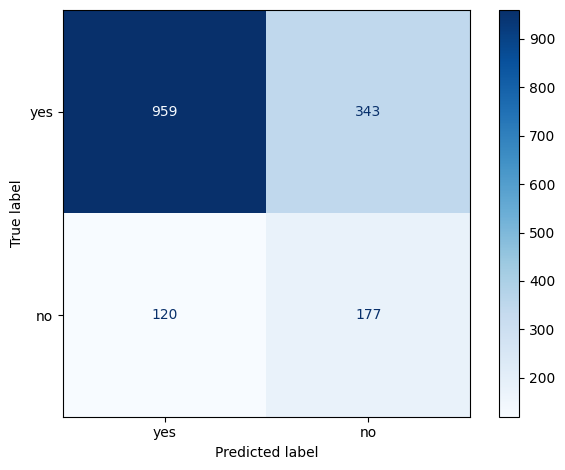

In [ ]:
# Target
y = df_filtered['relevance']

# Entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_words_df, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

#como tomamos
model_bernoulli = NaiveBayesClassifier(model_type='bernoulli', alpha=ALPHA)

model_bernoulli.fit(X_train.to_numpy(), y_train.to_list())

# Predicciones
y_pred_bernoulli = model_bernoulli.predict(X_test.to_numpy())

cm=confusion_matrix(y_test, y_pred_bernoulli)
print(classification_report(y_test, y_pred_bernoulli))
disp_bernoulli = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=y.unique())
disp_bernoulli.plot(cmap=plt.cm.Blues)


plt.tight_layout()
plt.show()

## 9. Balanceo del dataset

Aplicación de SMOTE para balancear las clases y se repite el entrenamiento y evaluación del modelo Bernoulli.

              precision    recall  f1-score   support

          no       0.82      0.94      0.88      1320
         yes       0.93      0.79      0.86      1309

    accuracy                           0.87      2629
   macro avg       0.88      0.87      0.87      2629
weighted avg       0.88      0.87      0.87      2629



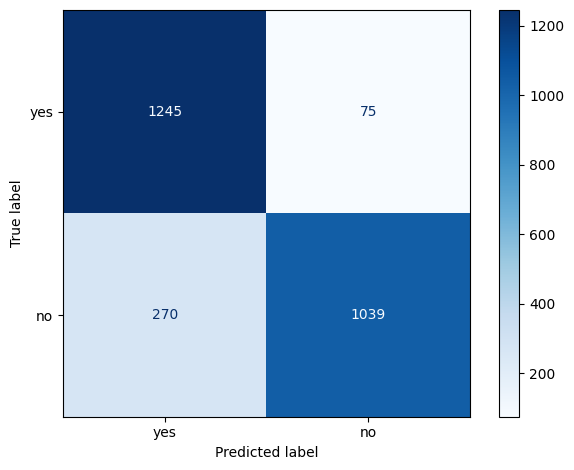

In [ ]:
# Balanceo
smote=SMOTE(random_state=RANDOM_STATE)
X_resampled, y_resampled = smote.fit_resample(X_words_df, y)

# Dividir ahora
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_resampled, y_resampled, test_size=TEST_SIZE, random_state=RANDOM_STATE)

model_bernoulli = NaiveBayesClassifier(model_type='bernoulli', alpha=ALPHA)

model_bernoulli.fit(X_train_bal.to_numpy(), y_train_bal.to_list())

# Predicciones
y_pred_b = model_bernoulli.predict(X_test_bal.to_numpy())
cm=confusion_matrix(y_test_bal, y_pred_b)
print(classification_report(y_test_bal, y_pred_b))
disp_bernoulli = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=y.unique())
disp_bernoulli.plot(cmap=plt.cm.Blues)

plt.tight_layout()
plt.show()

## 10. Modelo Multinomial (conteo de palabras)

Entrenamiento y evaluación del modelo Naive Bayes con variables de conteo, tanto en el dataset original como balanceado.

In [ ]:
# Conteo
# Convertimos el texto a palabras con CountVectorizer, contando las repeticiones de palabras
vectorizer = CountVectorizer(ngram_range=NGRAM_RANGE, max_features=MAX_FEATURES, stop_words=None, binary=False)
X_words = vectorizer.fit_transform(df_filtered['text'].astype(str))

# Convertimos a DataFrame
X_words_df = pd.DataFrame(X_words.toarray(), columns=vectorizer.get_feature_names_out())

# Revisar columnas
print(X_words_df.head())


   able  according  account  accounting  across  act  action  active  \
0     0          2        0           0       0    0       0       0   
1     0          0        0           0       0    0       0       0   
2     0          0        0           0       0    0       0       0   
3     0          1        0           0       0    0       0       0   
4     0          0        0           0       0    0       0       0   

   activity  actually  ...  year earlier  year old  year treasury  yen  \
0         0         0  ...             0         0              0    0   
1         0         0  ...             0         0              0    0   
2         0         0  ...             0         0              0    0   
3         0         0  ...             0         0              0    0   
4         0         0  ...             0         0              0    5   

   yesterday  yet  yield  york  york stock  zero  
0          1    0      4     2           0     0  
1          0    0   

# 11. Entrenamiento del modelo multinomial sin balancear

Entrenamiento y evaluación del modelo Multinomial sobre el dataset original (sin balancear), mostrando métricas y matriz de confusión.

              precision    recall  f1-score   support

          no       0.89      0.73      0.80      1302
         yes       0.34      0.60      0.43       297

    accuracy                           0.71      1599
   macro avg       0.61      0.67      0.62      1599
weighted avg       0.79      0.71      0.74      1599



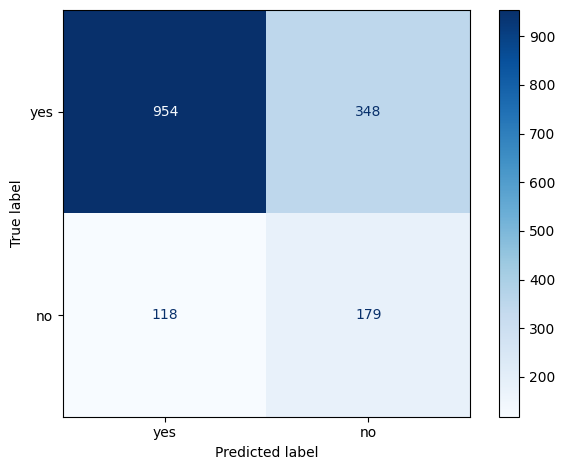

              precision    recall  f1-score   support

          no       0.89      0.73      0.80      1302
         yes       0.34      0.60      0.43       297

    accuracy                           0.71      1599
   macro avg       0.61      0.67      0.62      1599
weighted avg       0.79      0.71      0.74      1599



In [ ]:
# Probamos sin balancaer
model_multinomial = NaiveBayesClassifier(model_type='multinomial', alpha=ALPHA)

model_multinomial.fit(X_train.to_numpy(), y_train.to_list())

# Predicciones
y_pred_multi = model_multinomial.predict(X_test.to_numpy())
cm=confusion_matrix(y_test, y_pred_multi)
print(classification_report(y_test, y_pred_multi))
disp_multi = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=y.unique())
disp_multi.plot(cmap=plt.cm.Blues)

plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred_multi))

# 12. Entrenamiento mulinomial balanceado

Balanceo del dataset con SMOTE y nuevo entrenamiento del modelo Multinomial.
Evaluación del desempeño y visualización de los resultados, permitiendo una comparación con las otras variantes.

              precision    recall  f1-score   support

          no       0.77      0.80      0.79      1315
         yes       0.80      0.76      0.78      1314

    accuracy                           0.78      2629
   macro avg       0.78      0.78      0.78      2629
weighted avg       0.78      0.78      0.78      2629



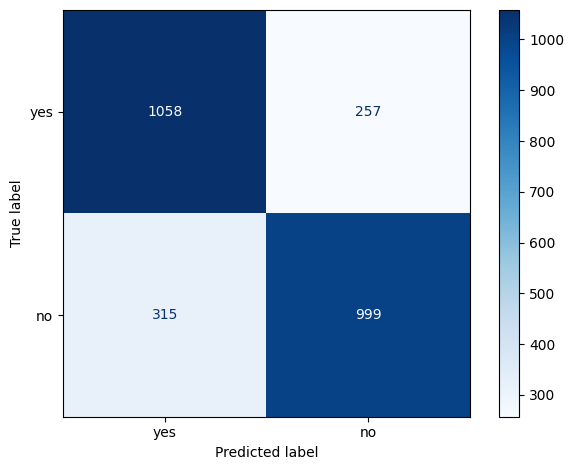

In [ ]:
# Balanceo
smote = SMOTE(random_state=RANDOM_STATE)
X_mres, y_mres = smote.fit_resample(X_words_df, y)

# Dividir ahora
X_train_mbal, X_test_mbal, y_train_mbal, y_test_mbal = train_test_split(X_mres, y_mres, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_mres)

model_multinomial = NaiveBayesClassifier(model_type='multinomial', alpha=ALPHA)
model_multinomial.fit(X_train_mbal.to_numpy(), y_train_mbal.to_list())

# Predicciones
y_pred_mb = model_multinomial.predict(X_test_mbal.to_numpy())

cm=confusion_matrix(y_test_mbal, y_pred_mb)
print(classification_report(y_test_mbal, y_pred_mb))
disp_bernoulli = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=y.unique())
disp_bernoulli.plot(cmap=plt.cm.Blues)

plt.tight_layout()
plt.show()

## 13. Comparación visual de modelos

Grafica de las métricas de accuracy y F1-score para las cuatro variantes:

*   Bernoulli sin balancear
*   Bernoulli balanceado
*   Multinomial sin balancear
*   Multinomial balanceado

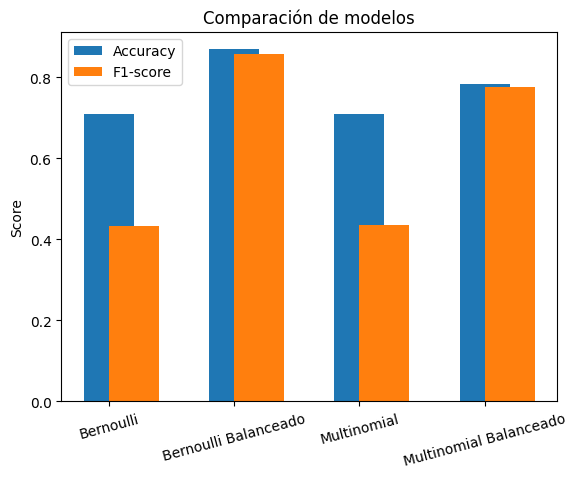

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

labels = [
    'Bernoulli',
    'Bernoulli Balanceado',
    'Multinomial',
    'Multinomial Balanceado'
]
accuracy = [
    accuracy_score(y_test, y_pred_bernoulli),
    accuracy_score(y_test_bal, y_pred_b),
    accuracy_score(y_test, y_pred_multi),
    accuracy_score(y_test_mbal, y_pred_mb)
]
f1 = [
    f1_score(y_test, y_pred_bernoulli, pos_label='yes'),
    f1_score(y_test_bal, y_pred_b, pos_label='yes'),
    f1_score(y_test, y_pred_multi, pos_label='yes'),
    f1_score(y_test_mbal, y_pred_mb, pos_label='yes')
]

import matplotlib.pyplot as plt

x = range(len(labels))
plt.bar(x, accuracy, width=0.4, label='Accuracy', align='center')
plt.bar(x, f1, width=0.4, label='F1-score', align='edge')
plt.xticks(x, labels, rotation=15)
plt.ylabel('Score')
plt.title('Comparación de modelos')
plt.legend()
plt.show()

## 14. Conclusión

El modelo Naive Bayes Bernoulli balanceado fue el que obtuvo mejores métricas de precisión y F1-score para predecir la relevancia de los textos. El balanceo de clases con SMOTE mejoró notablemente el desempeño respecto a los modelos entrenados con datos desbalanceados, tanto en la variante Bernoulli como en la Multinomial.
